Use conda environment `conda_envs/hic_nikita.yml` to run this notebook.

In [1]:
import sys
sys.path.append('scripts')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype

# Some additional for plots
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import cooler # Hi-C data processing
import cooltools
import networkx as nx # Network analysis
import pingouin as pg # Statistics

from sklearn.cluster import KMeans

# Some utils for notebook
from tqdm import tqdm
from IPython.display import display

# Custom
from my_loops_module import *
from my_network_utils import *

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_asy

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
from pandas.api.types import CategoricalDtype

chroms = Chromosome.chromosomes
regions_groups = {
    'Basal Nuclei': ['AMY', 'CMN', 'CaB', 'GPe', 'BNST', 'NAC', 'Pu'],
    'Basal Forebrain': ['SI', 'SEP'],
    'Cerebral cortex': ['MTG', 'LEC', 'A24', 'A46', 'FI', 'M1C', 'V1C', 'Pir']
}

regions_order = [reg for regs in regions_groups.values() for reg in regs]
reg_type = CategoricalDtype(categories=regions_order, ordered=True)
ct_type = CategoricalDtype(categories=['EN' , 'IN', 'NN'], ordered=True)
chr_type = CategoricalDtype(categories=chroms, ordered=True)


ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875"}
ct_palette = {"EN": "#cc3412",
              "IN": "#1375bc",
              "NN": "#009a88"}

def get_chr(loop_coords):
    chr1 = loop_coords[0][0]
    chr2 = loop_coords[1][0]
    return chr1 if chr1 == chr2 else 'trans'

chroms_colors = {chroms[i] : plt.get_cmap('tab20b')((i+1) / len(chroms)) for i in range(len(chroms[:-1])) }
chroms_colors['trans'] = (0,0,0)

# Input data:

- `/tank/projects/tian2023/cells_fullmeta_m3C.tsv` - snm3C-seq metadata from *Tian et al., 2023* 
- `data/Tian_cells_contacts_sums.csv` - table with extracted total numbers of contacts per cell from *Tian et al., 2023*
- `data/polycomb_dots_hand_coords_update_June25.tsv` - Polycomb dot coordinates identified in this paper
- `data/polycomb_dots_intensities_pad10kb_EN_IN_NN.csv` - Polycomb dot intensities identified in this paper (in notebook *code/Loops_vs_Expression/2_Get_sc_loops_intensities.ipynb*)
- `MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool` and `MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool` Hi-C maps aggregated from *Tian et al., 2023* snm3C-seq data

# Load data

In [7]:
tian_wd = '/tank/projects/tian2023/'
m3C_meta = pd.read_csv(os.path.join(tian_wd, 'cells_fullmeta_m3C.tsv'), sep='\t', index_col=0)
m3C_meta = m3C_meta.query('Cool_name != "GSM7346586_HBA_220615_H1930004_CX46_SEP_3C_2_P1-4-B11-M20.cool"')

cells_contact_sums = pd.read_csv('/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/Tian_cells_contacts_sums.csv', index_col=0)
cells_contact_sums.index.name = 'cell'

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [8]:
data_dir = '../../data/'

pcg_sc_loops = pd.read_csv(data_dir + 'polycomb_dots_intensities_pad10kb_EN_IN_NN.csv', header=[0,1])
print(pcg_sc_loops.shape)
cols = [ (c1, c2) for c1, c2 in pcg_sc_loops.columns.tolist()]
cols[0] = 'cell'
cols = list(map(lambda x: x if x == 'cell' else tuple([eval(x[0]), eval(x[1])]), cols))

pcg_sc_loops.columns = cols
pcg_sc_loops = pcg_sc_loops.dropna(subset=['cell']).set_index('cell')

(143759, 1514)


## Preprocess snm3C-seq *Loop x Cell* matrix

In [9]:
pcg_sc_loops.index = pcg_sc_loops.index.to_series().apply(lambda x: x.lstrip(r'GSM1234567890').removeprefix('_').removesuffix('.cool'))

cells = pcg_sc_loops.index.tolist()
pcg_sc_loops = pcg_sc_loops.T.reset_index()

In [10]:
pcg_sc_loops['loop'] =  pcg_sc_loops['index'].apply(lambda x: Loop(x))
pcg_sc_loops = pcg_sc_loops[['loop'] + cells]
pcg_sc_loops = pcg_sc_loops.sort_values(by='loop')

pcg_sc_loops_meta = pcg_sc_loops.sort_values(by=['loop'])\
                                .set_index('loop')\
                                .T\
                                .join(m3C_meta[['Region', 'CellClass', 'MajorType']])\
                                .astype({"Region": reg_type, "CellClass": ct_type})\
                                .set_index(['Region', 'CellClass', 'MajorType'], append=True)\
                                .sort_index(level=['CellClass', 'Region', 'MajorType'])

In [11]:
pcg_sc_loops_meta = (pcg_sc_loops_meta != 0).astype(int)
pcg_sc_loops_meta_norm = pcg_sc_loops_meta.div(cells_contact_sums.contacts_sum, axis=0)

In [12]:
pcg_sc_loops_meta_norm.shape

(143759, 1513)

In [13]:
pcg_sc_loops_meta.index.get_level_values('MajorType').value_counts()

MajorType
ODC            51538
L2/3-IT        14226
ASC            13463
MGC            10274
OPC             5127
Sst             4754
Vip             4666
MSN-D1          4418
MSN-D2          4083
L5-IT           3493
Pvalb           3456
Amy-Exc         3106
L4-IT           2791
Lamp5           2172
L6-IT           1908
Sncg            1826
L6-CT           1384
SubCtx-Cplx     1310
VLMC            1264
L6-IT-Car3      1208
Foxp2           1182
L6b             1094
EC              1068
Lamp5-Lhx6       976
PC               960
Pvalb-ChC        797
L5/6-NP          689
Chd7             399
L5-ET            127
Name: count, dtype: int64

## Filter cell types

In [14]:
blacklist = ['Amy-Exc', 'MSN-D1', 'MSN-D2', 'SubCtx-Cplx', 'Foxp2']
cell_counts = pcg_sc_loops_meta.index.get_level_values('MajorType').value_counts()
cell_counts = cell_counts[cell_counts>1500]


pcg_sc_loops_meta_norm = pcg_sc_loops_meta_norm.loc[[(ct in cell_counts) and (ct not in blacklist) for ct in pcg_sc_loops_meta_norm.index.get_level_values('MajorType')]]

# Aggregate cells by Cell Class (EN / IN / NN)

In [15]:
def group_and_normalize(df, col, div_by_total=False, add_total=True, return_cell_counts=False):
    values = df.groupby(col).sum()
    cells_counts = m3C_meta[col].value_counts().to_frame().loc[values.index]
    values_norm = values.div(cells_counts['count'], axis=0)
    total = values_norm.sum(axis=0, skipna=True)
    if div_by_total:
        values_norm = values_norm.div(total, axis=1)
    if add_total:
        values_norm.loc['Total'] = total
    if return_cell_counts:
        return values_norm, cells_counts
        
    return values_norm

In [16]:
pcg_sc_loops_meta_norm_grouped, cells_counts = group_and_normalize(pcg_sc_loops_meta_norm, 'CellClass', div_by_total=True, add_total=True, return_cell_counts=True)

## Visualize

totals - from merged maps

In [17]:
def ext(reg, pad=10_000):
    return reg[0], reg[1] - pad, reg[2] + pad

prefix = '/tank/projects/tian2023/mcools_fixed/'
mcool1 = prefix + 'MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool' + '::/resolutions/10000'
mcool2 = prefix + 'MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool' + '::/resolutions/10000'

mcools = [cooler.Cooler(f) for f in [mcool1, mcool2]]

In [18]:
for loop in tqdm(pcg_sc_loops_meta_norm_grouped.columns):
    lt = loop.tuple()
    total = [mcool.matrix(balance=False).fetch(ext(lt[0]), ext(lt[1])) for mcool in mcools]
    total = np.mean(total)
    pcg_sc_loops_meta_norm_grouped.loc['Total', loop] = total

100%|██████████| 1513/1513 [02:20<00:00, 10.73it/s]


<Axes: ylabel='CellClass'>

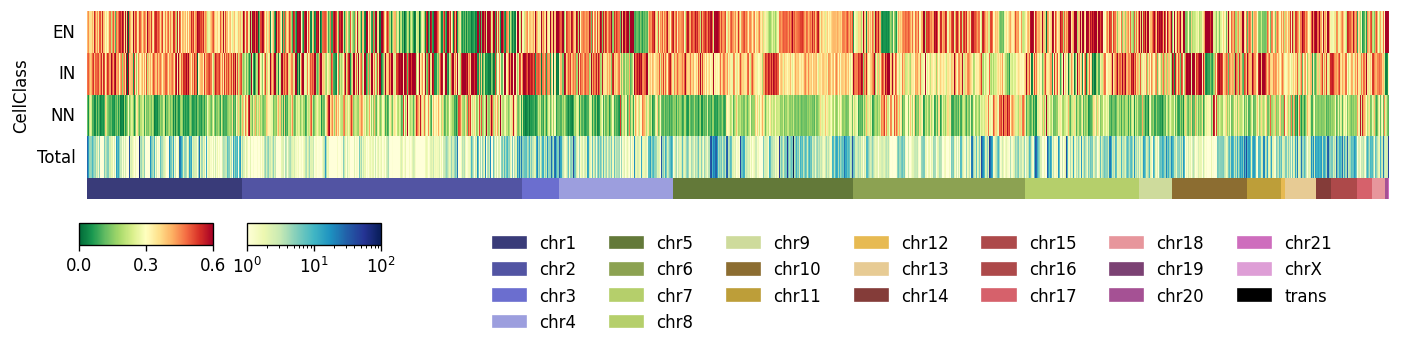

In [19]:
plot_heatmap_for_clusters(pcg_sc_loops_meta_norm_grouped, mins_maxs=(0, 0.6, 1, 100))

In [20]:
X = pcg_sc_loops_meta_norm_grouped.iloc[:3].T
n_clusters = 10

In [21]:
preds_raw = KMeans(n_clusters=n_clusters, random_state=1).fit_predict(X)
clusters_raw = list(set(preds_raw))

clusters_main_cts = dict()

clusters_main_cts_rev = {v:k for k, vs in clusters_main_cts.items() for v in vs}
preds = [clusters_main_cts_rev[p] if p in clusters_main_cts_rev else p for p in preds_raw]
clusters = list(clusters_main_cts.keys()) + list(clusters_raw - clusters_main_cts_rev.keys())

preds = pd.DataFrame({'preds': preds, 'preds_raw': preds_raw, 'loop':pcg_sc_loops_meta_norm_grouped.T.index})

preds['preds'] = preds['preds'].astype(CategoricalDtype(clusters, ordered=True))
preds['preds_raw'] = preds['preds_raw'].astype(CategoricalDtype(clusters_raw, ordered=True))
preds_ordered = preds.sort_values(by=['preds', 'loop'])# ['preds', 'preds_raw',  'loop']
pred_order_loops = preds_ordered.loop.to_list()

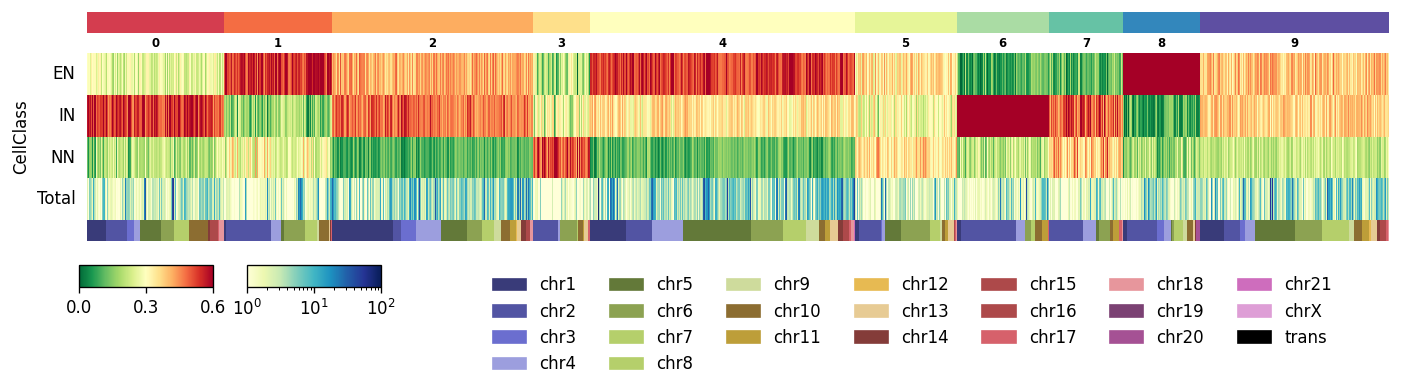

In [22]:
df_for_heatmap = pcg_sc_loops_meta_norm_grouped[pred_order_loops]

ax = plot_heatmap_for_clusters(df_for_heatmap, mins_maxs=(0, 0.6, 1, 100))

## Raw clusters
clusters_colors = {clusters_raw[i] : plt.get_cmap('Spectral')((i+1) / len(clusters_raw)) for i in range(len(clusters_raw)) }
for i, color in enumerate(preds_ordered['preds_raw'].cat.rename_categories(clusters_colors).values):
    rect = plt.Rectangle(xy=(i, -1), height=.5, width=1, color=color, lw=0, transform=ax.transData, clip_on=False)
    ax.add_patch(rect)

# ## Recoded clusters
# clusters_colors = {clusters[i] : plt.get_cmap('tab10')((i+1) / len(clusters)) for i in range(len(clusters)) }
# for i, color in enumerate(preds_ordered['preds'].cat.rename_categories(clusters_colors).values):
#     rect = plt.Rectangle(xy=(i, -.5), height=.5, width=1, color=color, lw=0, transform=ax.transData, clip_on=False)
#     ax.add_patch(rect)

pad = 0
sizes = preds_ordered['preds'].value_counts(sort=False).to_frame()
counts = [0] + sizes['count'].to_list()
for i, cluster in enumerate(preds_ordered['preds'].values):
    if i in [sum(counts[:i])+counts[i]//2 for i in range(0, len(counts))][1:]: 
        ax.annotate(cluster, (i, -.25 - pad), transform=ax.transData, annotation_clip=False, 
                    color='k', weight='bold', fontsize=7, ha='center', va='center')

In [23]:
clusters_main_cts = {
    'EN-specific': [8],
    'EN-prevalent': [1, 4],
    'Neuron-specific': [2, 9],
    'IN-prevalent': [0, 7],
    'IN-specific': [6],
    'NN-specific': [3],
    'Common': [5],
}
clusters_main_cts_rev = {v:k for k, vs in clusters_main_cts.items() for v in vs}
preds = [clusters_main_cts_rev[p] if p in clusters_main_cts_rev else p for p in preds_raw]
clusters = list(clusters_main_cts.keys()) + list(clusters_raw - clusters_main_cts_rev.keys())

preds = pd.DataFrame({'preds': preds, 'preds_raw': preds_raw, 'loop':pcg_sc_loops_meta_norm_grouped.T.index})
cols = list(pcg_sc_loops_meta_norm_grouped.index)

preds['preds'] = preds['preds'].astype(CategoricalDtype(clusters, ordered=True))
preds['preds_raw'] = preds['preds_raw'].astype(CategoricalDtype(clusters_raw, ordered=True))
preds_ordered = preds.sort_values(by=['preds', 'loop'])# ['preds', 'preds_raw',  'loop']
pred_order_loops = preds_ordered.loop.to_list()

In [24]:
palette = {
    "red": "#D7263D",                  # Beautiful rich red
    "blue": "#277DA1",                 # Deep oceanic blue
    "light_red_bg": "#F8C8C8",         # Desaturated, light red (good for background)
    "light_blue_bg": "#CFE8F3"         # Desaturated, light blue (good for background)
}
ct_palette = {"EN": "lightsalmon",
              "IN": "cornflowerblue",
              "NN": "#009a88"}

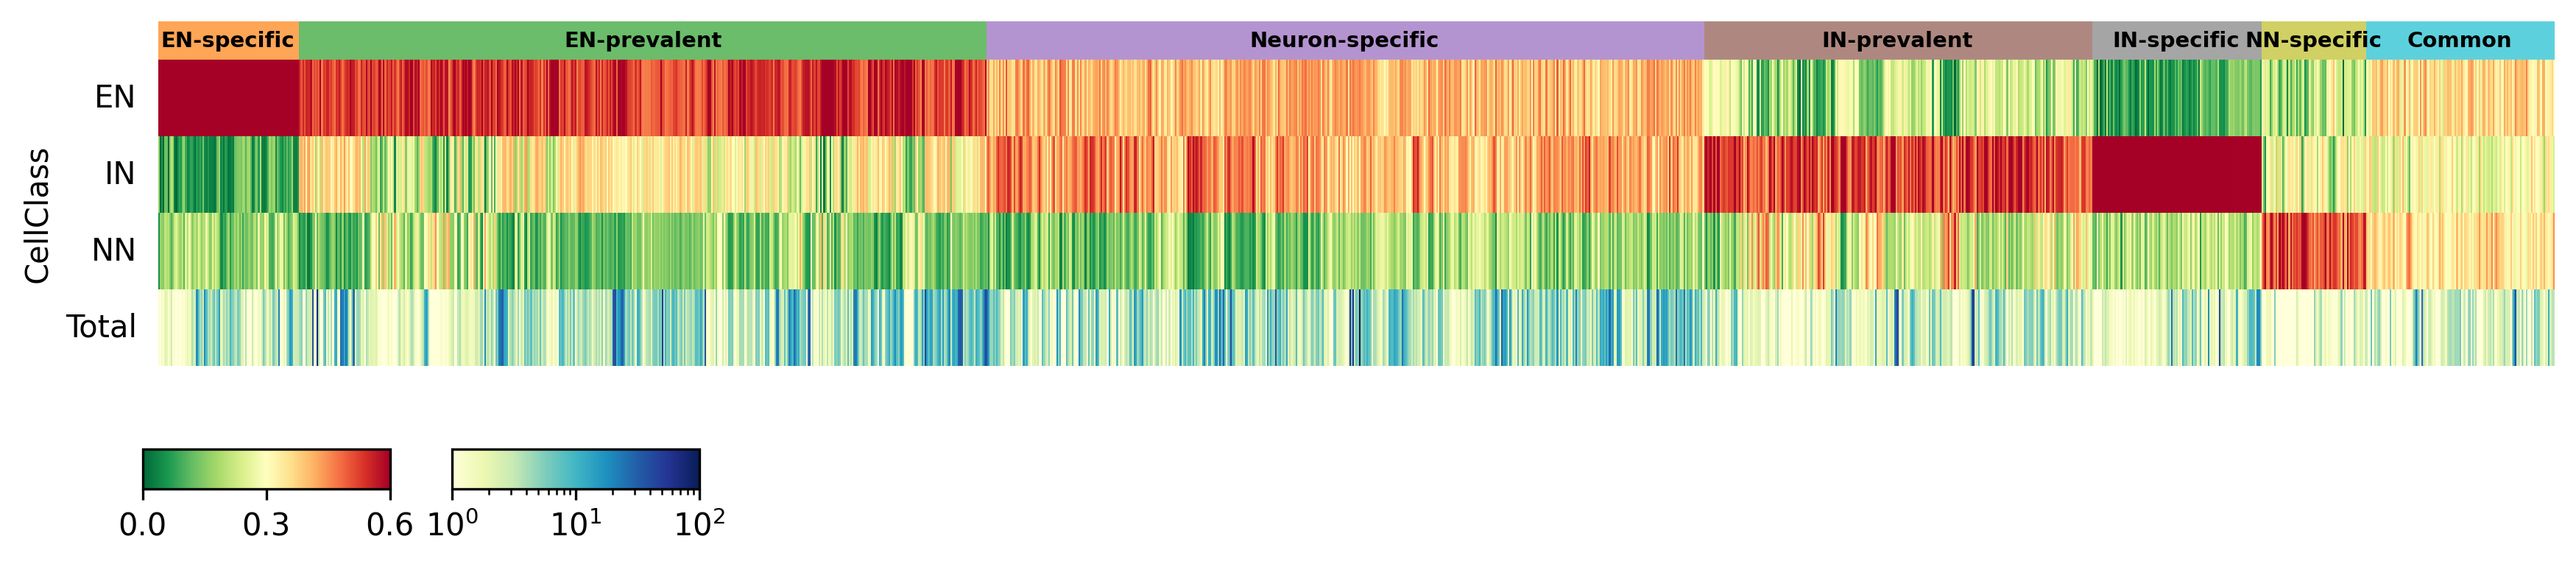

In [25]:
df_for_heatmap = pcg_sc_loops_meta_norm_grouped.loc[['EN', 'IN', 'NN'], pred_order_loops]
df_for_heatmap = pcg_sc_loops_meta_norm_grouped.loc[:,pred_order_loops]


ax = plot_heatmap_for_clusters(df_for_heatmap, mins_maxs=(0, 0.6, 1, 100), totals=True, add_chroms=False, dpi=300)


clusters_colors = {clusters[i] : plt.get_cmap('tab10')((i+1) / len(clusters)) for i in range(len(clusters)) }

i = 0
for color, w in preds_ordered['preds'].cat.rename_categories(clusters_colors).values.value_counts().to_dict().items():
    rect = plt.Rectangle(xy=(i, -.5), height=.5, width=w, color=color, alpha=0.7, lw=0, transform=ax.transData, clip_on=False)
    ax.add_patch(rect)
    i += w

pad = 0
sizes = preds_ordered['preds'].value_counts(sort=False).to_frame()
counts = [0] + sizes['count'].to_list()
for i, cluster in enumerate(preds_ordered['preds'].values):
    if i in [sum(counts[:i])+counts[i]//2 for i in range(0, len(counts))][1:]: 
        ax.annotate(cluster, (i, -.25 - pad), transform=ax.transData, annotation_clip=False, 
                    color='k', weight='bold', fontsize=7, ha='center', va='center')

# plt.savefig('imgs/Fig1a_PcG_loops_heatmap_by_CellClass.pdf', bbox_inches='tight')

In [27]:
preds[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']] = preds.loop.apply(lambda x: pd.Series((x.chrom1, x.start1, x.end1, x.chrom2, x.start2, x.end2)))
polycomb_loops_clusters = preds[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'loop', 'preds', 'preds_raw']].rename({'preds': 'cluster_name', 'preds_raw':'cluster_id'}, axis=1)

polycomb_dots = pd.read_csv('polycomb_dots_hand_coords_update_June25.tsv', sep='\t', index_col=0)
polycomb_loops_clusters = polycomb_loops_clusters.merge(polycomb_dots[['chrom1', 'start1', 'end1', 'gene1']].drop_duplicates(), how='left').merge(polycomb_dots[['chrom2', 'start2', 'end2', 'gene2']].drop_duplicates(), how='left')

polycomb_loops_clusters.gene1 = polycomb_loops_clusters.gene1.fillna('-')
polycomb_loops_clusters.gene2 = polycomb_loops_clusters.gene2.fillna('-')
polycomb_loops_clusters.to_csv(data + 'polycomb_loop_clusters_update_June25.tsv')

## Number of loops per anchor

In [40]:
polycomb_loops_clusters['anchor1'] = polycomb_loops_clusters.apply(lambda x: f"{x['chrom1']}-{x['start1']}-{x['start2']}", axis=1)
polycomb_loops_clusters['anchor2'] = polycomb_loops_clusters.apply(lambda x: f"{x['chrom2']}-{x['start2']}-{x['start2']}", axis=1)

In [70]:
all_loops = list(polycomb_loops_clusters.loop)
all_anchors = set([anc for loop in all_loops for anc in loop.tuple() ])

In [75]:
anch_counts = []

for anchor in tqdm(all_anchors):
    count = 0 
    for loop in all_loops:
        if anchor in loop.tuple():
            count +=1
    anch_counts.append({'Anchor': anchor, 'N_loops': count})

100%|██████████| 254/254 [00:02<00:00, 95.75it/s]


In [78]:
anch_counts = pd.DataFrame(anch_counts)

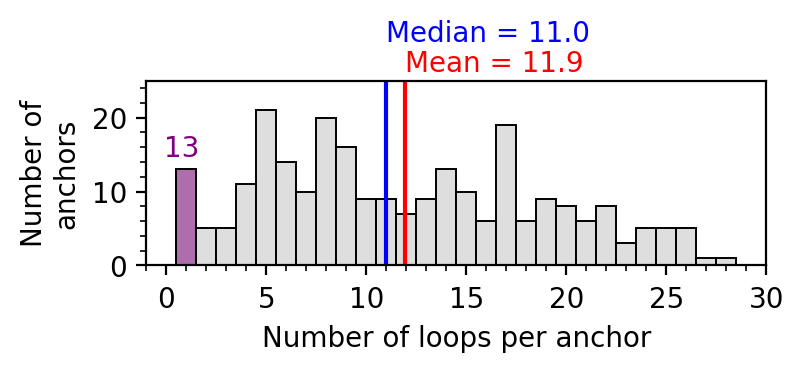

In [139]:
plt.figure(figsize=(4, 1.2), dpi=200)

ax = sns.histplot(anch_counts, x='N_loops',
                  bins=np.arange(0.5, 30.5, step=1),
                  color='lightgrey'
                  # hue='CellClass', palette=my_pal
                   );

plt.axvline(x=anch_counts.N_loops.mean(), color='r')
plt.axvline(x=anch_counts.N_loops.median(), color='b')

plt.text(x=anch_counts.N_loops.mean(), y=1.02, 
         s =f'Mean = {anch_counts.N_loops.mean():.1f} ' , 
         color='r', ha='left', va='bottom', fontsize=10,
        transform=ax.get_xaxis_transform())

plt.text(x=anch_counts.N_loops.median(), y=1.18, 
         s =f'Median = {anch_counts.N_loops.median():.1f} ' , 
         color='b', ha='left', va='bottom', fontsize=10,
         transform=ax.get_xaxis_transform())

ax = sns.histplot(anch_counts, x='N_loops',
                  bins=np.arange(0.5, 2.5, step=1),
                  color='purple', alpha=0.5
                  # hue='CellClass', palette=my_pal
                   );
plt.text(x=1, y=14, 
         s =f'{anch_counts.N_loops.value_counts().at[1]:.0f} ' , 
         color='purple', ha='center', va='bottom', fontsize=10,
         # transform=ax.get_xaxis_transform()
)

plt.minorticks_on()
plt.xlabel('Number of loops per anchor')
plt.ylabel('Number of\nanchors')
plt.ylim((0, 25))
plt.xlim((-1, 30))
# plt.savefig('imgs/FigS1xx_Loops_per_anchors.pdf', bbox_inches='tight')

## Check how loops share anchors

In [28]:
cluster_loops = polycomb_loops_clusters.groupby('cluster_name')['loop'].agg(list).to_dict()
cluster_loops = {k: [v.tuple() for v  in vs] for k, vs in cluster_loops.items()}
cluster_anchors = {k: set([anc for loop in loops for anc in loop ]) for k, loops in cluster_loops.items()}

In [29]:
from matplotlib_venn import venn3
from matplotlib_venn import venn3, venn3_circles
ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875",
              'Other': 'grey',
              'Neurons': '#bebf23'}

Text(0.5, 1.0, 'Anchors shared bettween loops')

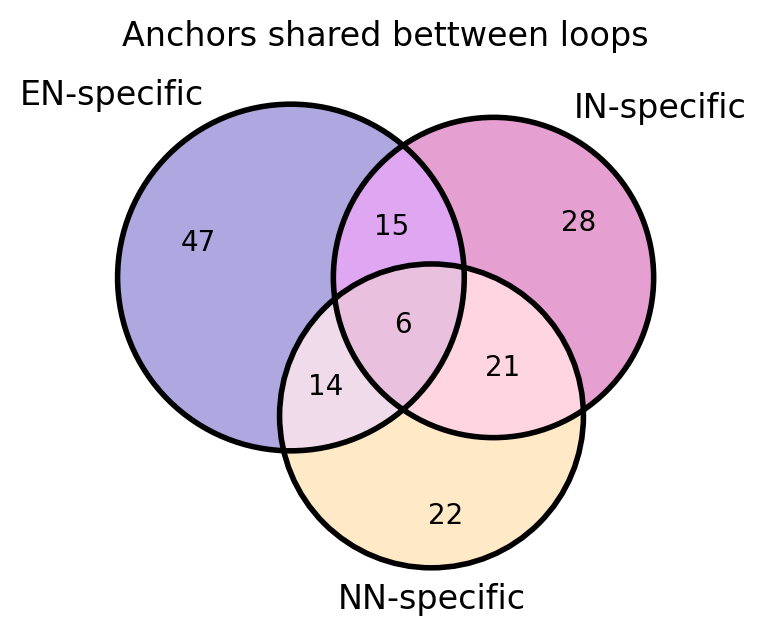

In [30]:
plt.figure(figsize=(4,4), dpi=200)

clusters = ('EN-specific', 'IN-specific', 'NN-specific')
set1 = cluster_anchors[clusters[0]]
set2 = cluster_anchors[clusters[1]]
set3 = cluster_anchors[clusters[2]]
venn3([set1, set2, set3], clusters, (ct_palette['EN'], ct_palette['IN'], ct_palette['NN']))
venn3_circles([set1, set2, set3]);

plt.title('Anchors shared bettween loops')

Text(0.5, 1.0, 'Anchors shared bettween loops')

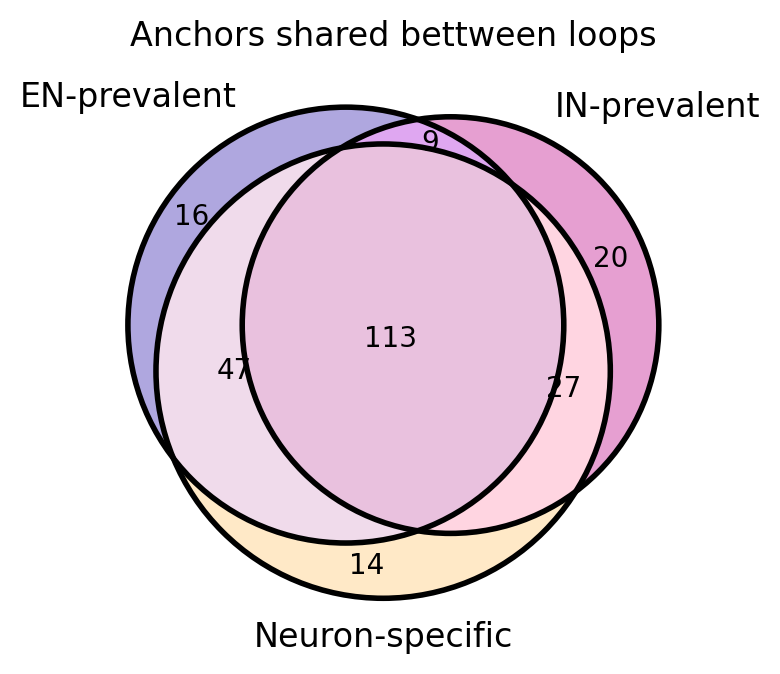

In [31]:
plt.figure(figsize=(4,4), dpi=200)

clusters = ('EN-prevalent', 'IN-prevalent', 'Neuron-specific')
set1 = cluster_anchors[clusters[0]]
set2 = cluster_anchors[clusters[1]]
set3 = cluster_anchors[clusters[2]]
venn3([set1, set2, set3], clusters, (ct_palette['EN'], ct_palette['IN'], ct_palette['NN']))
venn3_circles([set1, set2, set3]);
plt.title('Anchors shared bettween loops')

Text(0.5, 0.98, 'Anchors shared bettween loops')

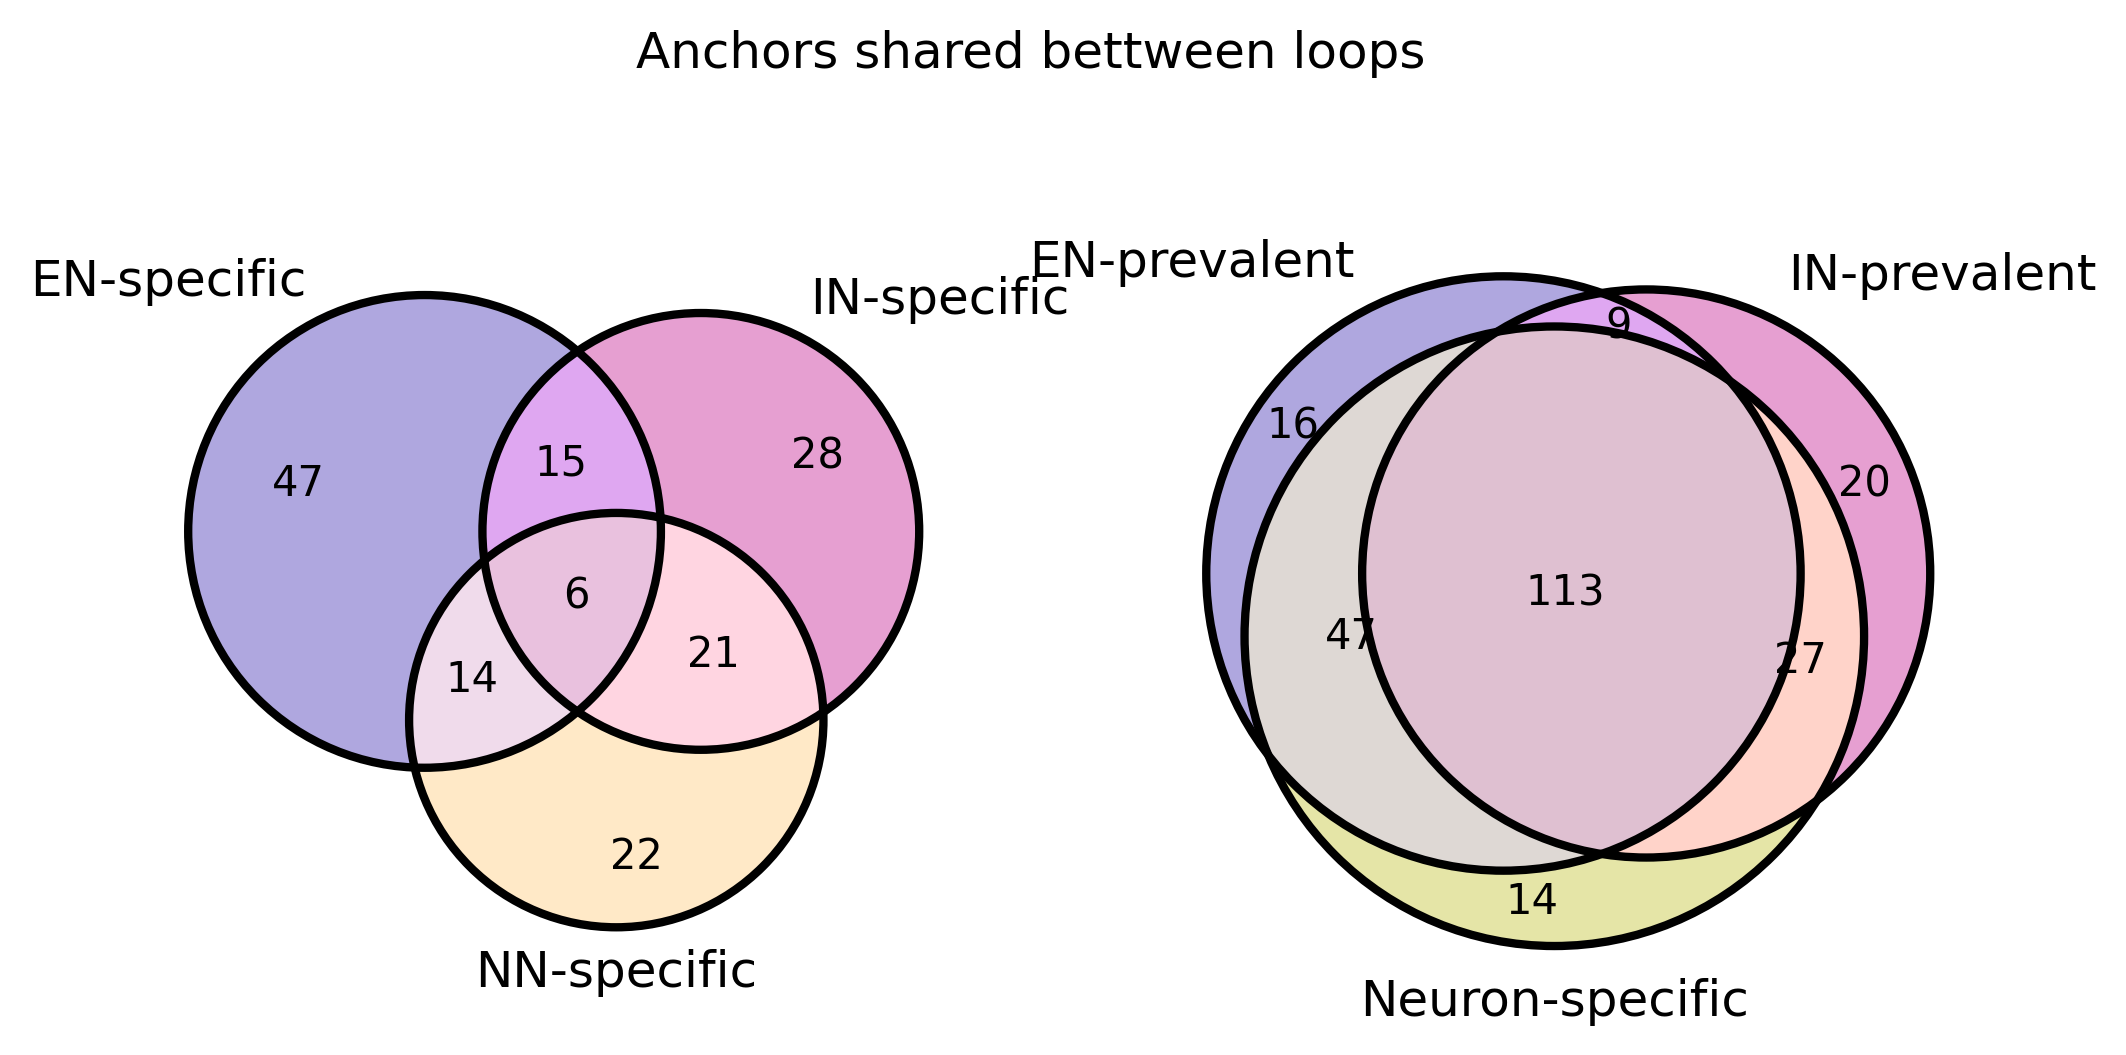

In [32]:
fig, axs = plt.subplots(ncols=2,figsize=(8,4), dpi=300)


clusters = ('EN-specific', 'IN-specific', 'NN-specific')
set1 = cluster_anchors[clusters[0]]
set2 = cluster_anchors[clusters[1]]
set3 = cluster_anchors[clusters[2]]
venn3([set1, set2, set3], clusters, (ct_palette['EN'], ct_palette['IN'], ct_palette['NN']), ax=axs[0])
venn3_circles([set1, set2, set3], ax=axs[0]);

clusters = ('EN-prevalent', 'IN-prevalent', 'Neuron-specific')
set1 = cluster_anchors[clusters[0]]
set2 = cluster_anchors[clusters[1]]
set3 = cluster_anchors[clusters[2]]
venn3([set1, set2, set3], clusters, (ct_palette['EN'], ct_palette['IN'], ct_palette['Neurons']), ax=axs[1])
venn3_circles([set1, set2, set3], ax=axs[1]);

plt.suptitle('Anchors shared bettween loops')
# plt.savefig('imgs/FigS1F_Venns_for_shared_anchors.pdf', bbox_inches='tight')

# Aggregate ceels by MajorType

In [78]:
pcg_sc_loops_meta_norm_grouped, cells_counts = group_and_normalize(pcg_sc_loops_meta_norm, 'MajorType', div_by_total=True, add_total=False, return_cell_counts=True)

# maj_type_ordered = [
#     'DG', 'CA3', 'CA1', 'HIP-Misc1', 'HIP-Misc2', 'L4-IT', 'L5-IT', 'L5-ET', 'Amy-Exc', 
#     'L2/3-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6b', 'L6-CT', 'Foxp2', 'MSN-D1', 
#     'MSN-D2', 'Chd7', 'Vip', 'Sncg', 'Lamp5-Lhx6', 'Lamp5', 'Sst', 'Pvalb', 'Pvalb-ChC', 
#     'SubCtx-Cplx', 'THM-Inh', 'THM-Exc', 'PN', 'PKJ', 'CB', 'VLMC', 'OPC', 'MGC', 'PC', 'EC',
#     'ODC', 'ASC'
# ]

# to_save_whole = pcg_sc_loops_meta_norm_grouped.copy()
# to_save_whole.index = to_save_whole.index.astype(CategoricalDtype(maj_type_ordered, ordered=True))
# to_save_whole = to_save_whole.sort_index()
# to_save_whole = to_save_whole.fillna(0)

# to_save_whole.to_pickle(data + 'pcg_loops_groupedMaJType_norm_whole.pkl')

In [79]:
pcg_sc_loops_meta_norm_grouped.index

Index(['ASC', 'L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'Lamp5', 'MGC', 'ODC',
       'OPC', 'Pvalb', 'Sncg', 'Sst', 'Vip'],
      dtype='object', name='MajorType')

In [80]:
pcg_sc_loops_meta_norm_grouped = pcg_sc_loops_meta_norm_grouped.loc[cells_counts.query('count > 1500').index]

cell_types_from_ilya = [
    "L2/3-IT", "L4-IT", "L5-IT", "L6-IT", #"L6-IT-Car3", "L6b", "L6-CT",
    "Pvalb", "Sst", "Lamp5",  "Sncg" ,"Vip",
    'OPC', 'ODC', 'MGC', 'ASC',
    #"Lamp5-Lhx6", 
    
]
maj_type_ordered = cell_types_from_ilya
pcg_sc_loops_meta_norm_grouped = pcg_sc_loops_meta_norm_grouped.loc[cell_types_from_ilya]

pcg_sc_loops_meta_norm_grouped.index = pcg_sc_loops_meta_norm_grouped.index.astype(CategoricalDtype(maj_type_ordered, ordered=True))
pcg_sc_loops_meta_norm_grouped = pcg_sc_loops_meta_norm_grouped.sort_index()
pcg_sc_loops_meta_norm_grouped = pcg_sc_loops_meta_norm_grouped.fillna(0)

<Axes: ylabel='MajorType'>

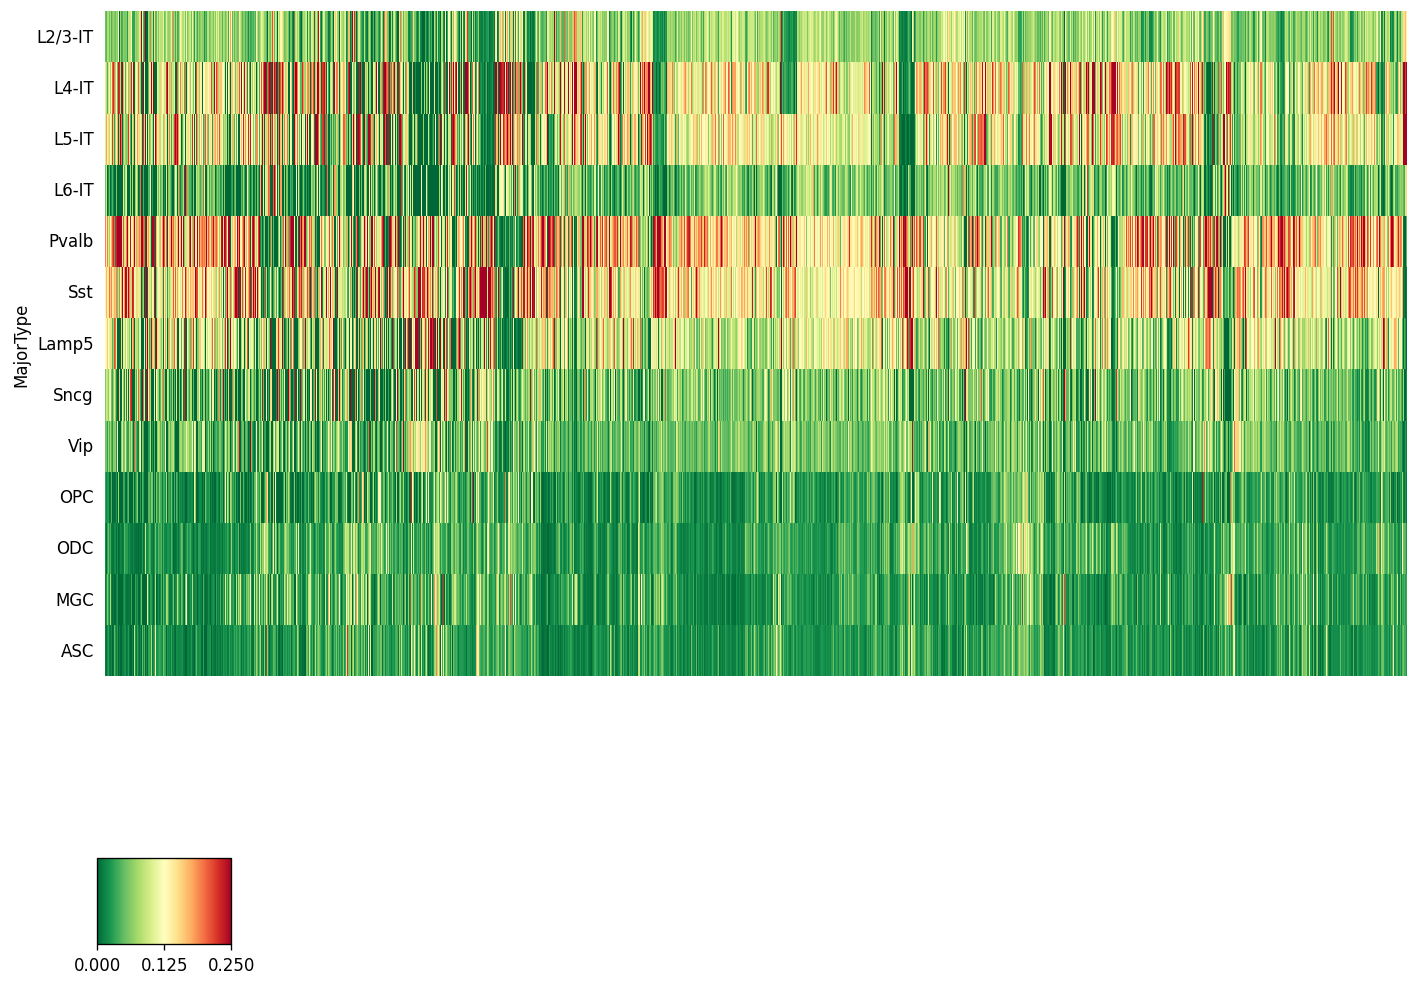

In [81]:
plot_heatmap_for_clusters(pcg_sc_loops_meta_norm_grouped, mins_maxs=(0, 0.25), totals=False, add_chroms=False)

In [82]:
X = pcg_sc_loops_meta_norm_grouped.T
n_clusters = 15

In [83]:
preds_raw = KMeans(n_clusters=n_clusters, random_state=1).fit_predict(X)
clusters_raw = list(set(preds_raw))

clusters_main_cts = dict()
clusters_main_cts_rev = {v:k for k, vs in clusters_main_cts.items() for v in vs}
preds = [clusters_main_cts_rev[p] if p in clusters_main_cts_rev else p for p in preds_raw]
clusters = list(clusters_main_cts.keys()) + list(clusters_raw - clusters_main_cts_rev.keys())

preds = pd.DataFrame({'preds': preds, 'preds_raw': preds_raw, 'loop':pcg_sc_loops_meta_norm_grouped.T.index})

preds['preds'] = preds['preds'].astype(CategoricalDtype(clusters, ordered=True))
preds['preds_raw'] = preds['preds_raw'].astype(CategoricalDtype(clusters_raw, ordered=True))
preds_ordered = preds.sort_values(by=['preds', 'loop'])# ['preds', 'preds_raw',  'loop']
pred_order_loops = preds_ordered.loop.to_list()

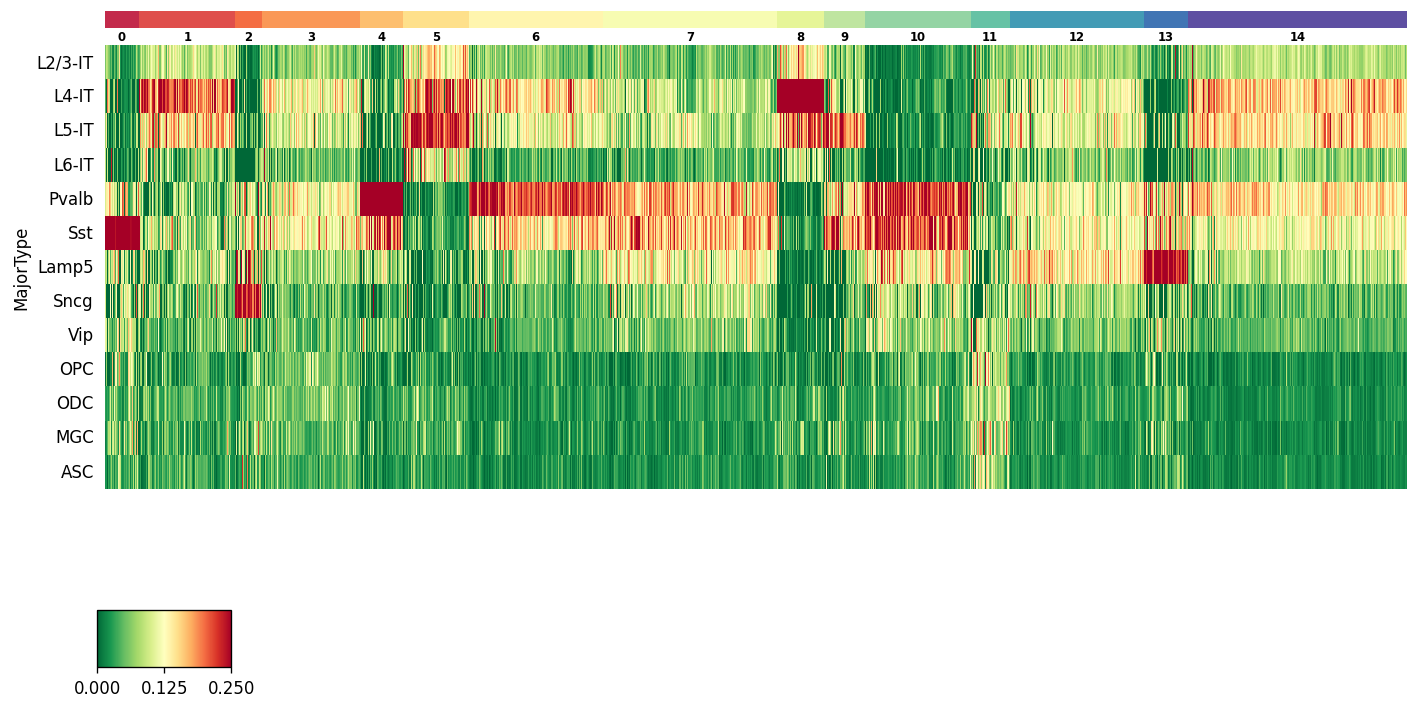

In [84]:
df_for_heatmap = pcg_sc_loops_meta_norm_grouped[pred_order_loops]

ax = plot_heatmap_for_clusters(df_for_heatmap, mins_maxs=(0, 0.25), totals=False, add_chroms=False, rw=0.4)

## Raw clusters
clusters_colors = {clusters_raw[i] : plt.get_cmap('Spectral')((i+1) / len(clusters_raw)) for i in range(len(clusters_raw)) }
for i, color in enumerate(preds_ordered['preds_raw'].cat.rename_categories(clusters_colors).values):
    rect = plt.Rectangle(xy=(i, -1), height=.5, width=1, color=color, lw=0, transform=ax.transData, clip_on=False)
    ax.add_patch(rect)

# ## Recoded clusters
# clusters_colors = {clusters[i] : plt.get_cmap('tab10')((i+1) / len(clusters)) for i in range(len(clusters)) }
# for i, color in enumerate(preds_ordered['preds'].cat.rename_categories(clusters_colors).values):
#     rect = plt.Rectangle(xy=(i, -.5), height=.5, width=1, color=color, lw=0, transform=ax.transData, clip_on=False)
#     ax.add_patch(rect)

pad = 0
sizes = preds_ordered['preds'].value_counts(sort=False).to_frame()
counts = [0] + sizes['count'].to_list()
for i, cluster in enumerate(preds_ordered['preds'].values):
    if i in [sum(counts[:i])+counts[i]//2 for i in range(0, len(counts))][1:]: 
        ax.annotate(cluster, (i, -.25 - pad), transform=ax.transData, annotation_clip=False, 
                    color='k', weight='bold', fontsize=7, ha='center', va='center')

In [85]:
clusters_main_cts = {
'L4': [8],
'EN': [1,5],
'Neurons': [6, 7, 9, 12, 14],
'IN': [10],
'Pvalb': [4],
'Sst': [0],
'Lamp5': [13],
'Sncg': [2],
'Common': [3, 11],
}

clusters_main_cts_rev = {v:k for k, vs in clusters_main_cts.items() for v in vs}
preds = [clusters_main_cts_rev[p] if p in clusters_main_cts_rev else p for p in preds_raw]
clusters = list(clusters_main_cts.keys()) + list(clusters_raw - clusters_main_cts_rev.keys())

preds = pd.DataFrame({'preds': preds, 'preds_raw': preds_raw, 'loop':pcg_sc_loops_meta_norm_grouped.T.index})
cols = list(pcg_sc_loops_meta_norm_grouped.index)

preds['preds'] = preds['preds'].astype(CategoricalDtype(clusters, ordered=True))
preds['preds_raw'] = preds['preds_raw'].astype(CategoricalDtype(clusters_raw, ordered=True))
preds_ordered = preds.sort_values(by=['preds', 'loop'])# ['preds', 'preds_raw',  'loop']
pred_order_loops = preds_ordered.loop.to_list()

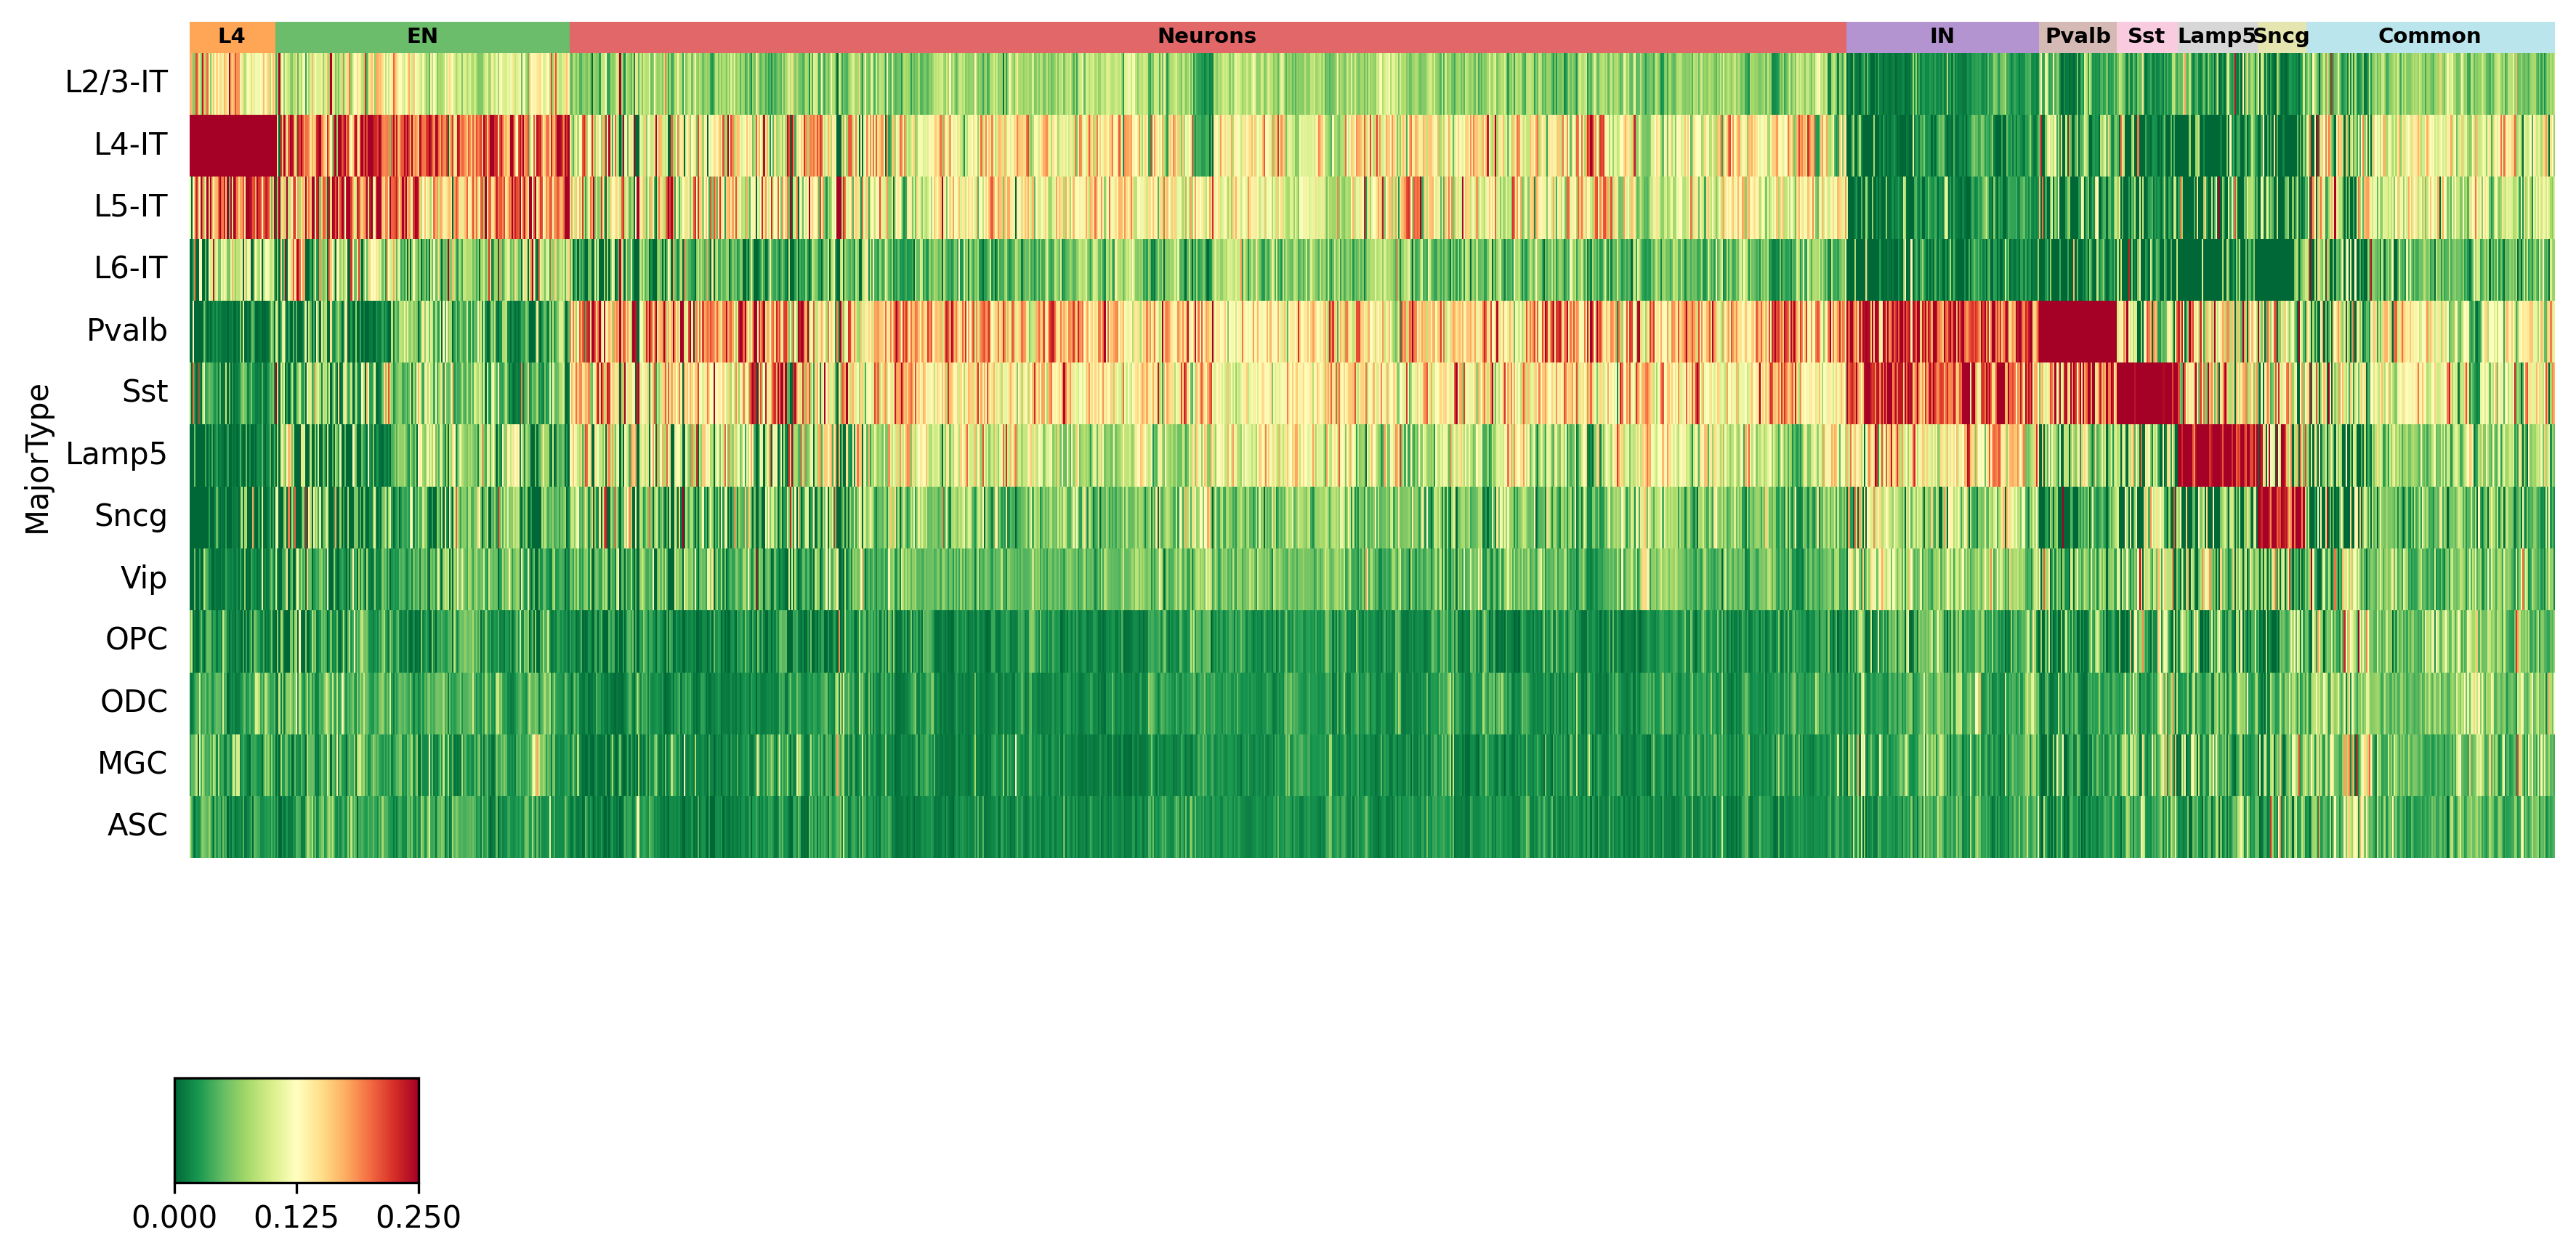

In [87]:
df_for_heatmap = pcg_sc_loops_meta_norm_grouped[pred_order_loops]

ax = plot_heatmap_for_clusters(df_for_heatmap, mins_maxs=(0, 0.25), totals=False, add_chroms=False, rw=0.4, dpi=300)


clusters_colors = {clusters[i] : plt.get_cmap('tab20')((i+1) / len(clusters)) for i in range(len(clusters)) }
i = 0
for color, w in preds_ordered['preds'].cat.rename_categories(clusters_colors).values.value_counts().to_dict().items():
    rect = plt.Rectangle(xy=(i, -.5), height=.5, width=w, color=color, alpha=0.7, lw=0, transform=ax.transData, clip_on=False)
    ax.add_patch(rect)
    i += w

pad = 0
sizes = preds_ordered['preds'].value_counts(sort=False).to_frame()
counts = [0] + sizes['count'].to_list()
for i, cluster in enumerate(preds_ordered['preds'].values):
    if i in [sum(counts[:i])+counts[i]//2 for i in range(0, len(counts))][1:]: 
        ax.annotate(cluster, (i, -.25 - pad), transform=ax.transData, annotation_clip=False, 
                    color='k', weight='bold', fontsize=7, ha='center', va='center')

# plt.savefig('imgs/FigS2a_PcG_loops_heatmap_by_MajType.pdf', bbox_inches='tight')

In [88]:
preds[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']] = preds.loop.apply(lambda x: pd.Series((x.chrom1, x.start1, x.end1, x.chrom2, x.start2, x.end2)))
polycomb_loops_clusters = preds[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'loop', 'preds', 'preds_raw']].rename({'preds': 'cluster_name', 'preds_raw':'cluster_id'}, axis=1)

polycomb_dots = pd.read_csv(data + 'polycomb_dots_hand_coords_update_June25.tsv', sep='\t', index_col=0)
polycomb_loops_clusters = polycomb_loops_clusters.merge(polycomb_dots[['chrom1', 'start1', 'end1', 'gene1']].drop_duplicates(), how='left').merge(polycomb_dots[['chrom2', 'start2', 'end2', 'gene2']].drop_duplicates(), how='left')

polycomb_loops_clusters.gene1 = polycomb_loops_clusters.gene1.fillna('-')
polycomb_loops_clusters.gene2 = polycomb_loops_clusters.gene2.fillna('-')
polycomb_loops_clusters.to_csv(data + 'polycomb_loop_clusters_MajType_update_June25.tsv')

In [89]:
pcg_sc_loops_meta_norm_grouped.to_pickle(data + 'pcg_loops_groupedMaJType_norm_whole_update_June25.pkl')